In [1]:
# Imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import glob

In [30]:
# Load HyDE-DF results
    
def load_data(folder_results):
    
    folders = glob.glob('results/'+folder_results+'/*')
    results = {}
    for folder in folders:
        # Setup the folder name for the dictionary
        folder_name = folder.split('\\')[-1]

        # Setup the temporary dictionary for the run
        temp_dict = {}

        files = glob.glob(folder+'/*.csv')
        for file in files:
            file_name = file.split('\\')[-1].split('.')[0]
            temp_dict[file_name] = pd.read_csv(file, header=0, index_col=0)

        results[folder_name] = temp_dict
        
    return results

results_hyde = load_data('paper_hyde')
results_de = load_data('paper_de')
results_ga = load_data('paper_ga')
results_pso = load_data('paper_pso')

In [33]:
# Decode solution vector aux

def encode(var_dictionary):
    result_concat = np.concatenate([var_dictionary[v].ravel() for v in var_dictionary.keys()])
    return result_concat


def decode(var_vector, var_dictionary):
    result_decoded = {}
    var_idx = [var_dictionary[v].ravel().shape[0] for v in var_dictionary.keys()]

    current_index = 0
    dictionary_names = list(var_dictionary.keys())
    
    for idx in np.arange(len(dictionary_names)):
        result_index = current_index + var_idx[idx]
        result_decoded[dictionary_names[idx]] = np.reshape(var_vector[current_index:result_index], 
                                                           var_dictionary[dictionary_names[idx]].shape)
        
        current_index = result_index
        
    return result_decoded

In [36]:
# Build dictionary for decoding

_gen = 7
_t = 24
_Load = 6
_stor = 3
_v2g = 5
_cs = 3

# Positive variables

# Generation variables
genActPower = np.ones(shape=(_gen, _t))
genExcActPower = np.ones(shape=(_gen, _t))
pImp = np.ones(shape=(_t))
pExp = np.ones(shape=(_t))

# Load variables
loadRedActPower = np.ones(shape=(_Load, _t))
loadCutActPower = np.ones(shape=(_Load, _t))
loadENS = np.ones(shape=(_Load, _t))

# Storage variables
storDchActPower = np.ones(shape=(_stor, _t))
storChActPower = np.ones(shape=(_stor, _t))
storEminRelaxStor = np.ones(shape=(_stor, _t))
storEnerState = np.ones(shape=(_stor, _t))

# V2G variables
v2gDchActPower = np.ones(shape=(_v2g, _t))
v2gChActPower = np.ones(shape=(_v2g, _t))
v2gEnerState = np.ones(shape=(_v2g, _t))
v2gEminRelaxEv = np.ones(shape=(_v2g, _t))

# Charging Stations
csActPower = np.ones(shape=(_cs, _t))
csActPowerNet = np.ones(shape=(_cs, _t))

# Binary variables
genXo = np.zeros(shape=(_gen, _t))
loadXo = np.zeros(shape=(_Load, _t))

storChXo = np.zeros(shape=(_stor, _t))
storDchXo = np.zeros(shape=(_stor, _t))

v2gChXo = np.zeros(shape=(_v2g, _t))
v2gDchXo = np.zeros(shape=(_v2g, _t))


dict_var = {'genActPower': genActPower,
            'genExcActPower': genExcActPower,
            'pImp': pImp,
            'pExp': pExp,
            'loadRedActPower': loadRedActPower,
            'loadENS': loadENS,
            'storDchActPower': storDchActPower,
            'storChActPower': storChActPower,
            'EminRelaxStor': storEminRelaxStor,
            'genXo': genXo,
            'loadXo': loadXo,
            'storDchXo': storDchXo,
            'storChXo': storChXo,
            'v2gDchXo': v2gDchXo,
            'v2gChXo': v2gChXo}

In [43]:
# Decode the solutions

def decode_results(results_dict):
    temp_dict = {}
    for key in results_dict.keys():
        temp_dict[key] = decode(results_dict[key]['solution'].values.ravel(), dict_var)
        
    return temp_dict

decoded_de = decode_results(results_de)
decoded_ga = decode_results(results_ga)
decoded_pso = decode_results(results_pso)

In [176]:
# Get run times

df_times = pd.DataFrame({'HyDE-DF': [results_hyde['run{:02d}'.format(i)]['overall']['Time'].values[0] 
                                     for i in np.arange(1, 11)],
                         'DE': [results_de['run{:02d}'.format(i)]['stats']['runtime'].values[0] 
                                for i in np.arange(1, 11)],
                         'GA': [results_ga['run{:02d}'.format(i)]['stats']['runtime'].values[0] 
                                for i in np.arange(1, 11)],
                         'PSO': [results_pso['run{:02d}'.format(i)]['stats']['runtime'].values[0] 
                                 for i in np.arange(1, 11)]}) 


df_it = pd.DataFrame({'HyDE-DF': [50000 for i in np.arange(10)],
                      'DE': [50000 for i in np.arange(10)],
                      'GA': [50000 for i in np.arange(10)],
                      'PSO': [6367, 5782, 5995, 7053, 6559, 5960, 6928, 7580, 5722, 5902]})

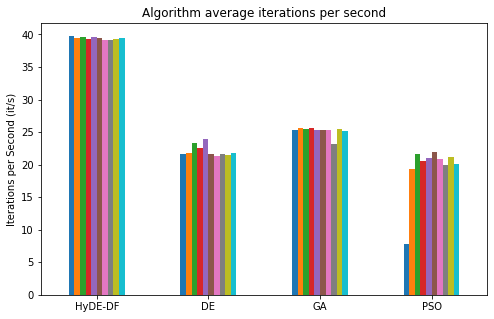

In [182]:
# Plot the execution times

(df_it / df_times).transpose().plot(kind='bar', legend=None, figsize=(8, 5))
plt.xticks(rotation=0)

plt.title('Algorithm average iterations per second')
plt.ylabel('Iterations per Second (it/s)')

plt.show()

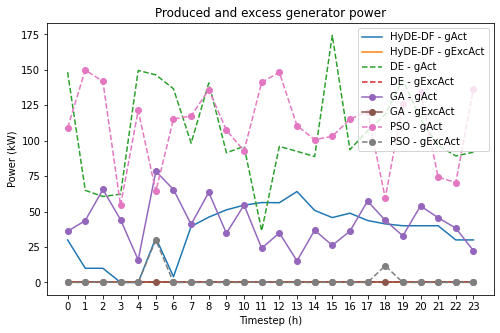

In [299]:
# Plot the total amount of generated power and exc. power for the best runs

fig = plt.figure(figsize=(8, 5))

plt.plot(np.sum(results_hyde['run05']['genActPower'], axis=0), label='HyDE-DF - gAct')
plt.plot(np.sum(results_hyde['run05']['genExcActPower'], axis=0), label='HyDE-DF - gExcAct')

plt.plot(np.sum(decoded_de['run07']['genActPower'], axis=0), '--', label='DE - gAct')
plt.plot(np.sum(decoded_de['run07']['genExcActPower'], axis=0), '--', label='DE - gExcAct')

plt.plot(np.sum(decoded_ga['run02']['genActPower'], axis=0), '-o', label='GA - gAct')
plt.plot(np.sum(decoded_ga['run02']['genExcActPower'], axis=0), '-o', label='GA - gExcAct')

plt.plot(np.sum(decoded_pso['run09']['genActPower'], axis=0), 'o--', label='PSO - gAct')
plt.plot(np.sum(decoded_pso['run09']['genExcActPower'], axis=0), 'o--', label='PSO - gExcAct')

plt.legend()
plt.title('Produced and excess generator power')

plt.ylabel('Power (kW)')
plt.xlabel('Timestep (h)')

plt.show()

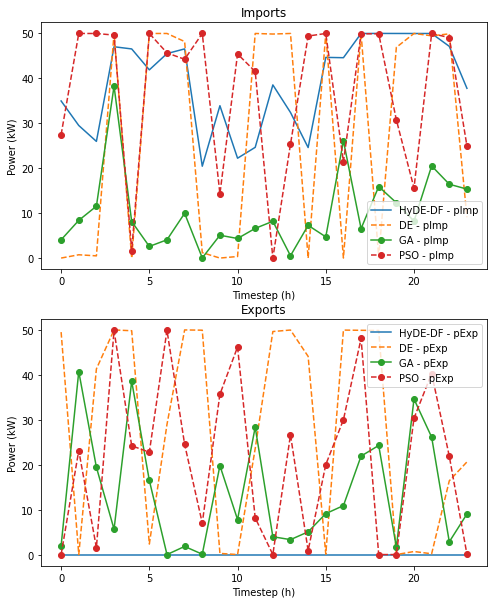

In [300]:
# Plot the imports and export

fig, axs = plt.subplots(nrows=2, figsize=(8, 10))

# Plot 
axs[0].plot(results_hyde['run06']['pImp'], label='HyDE-DF - pImp')
axs[1].plot(results_hyde['run06']['pExp'], label='HyDE-DF - pExp')

axs[0].plot(decoded_de['run07']['pImp'], '--', label='DE - pImp')
axs[1].plot(decoded_de['run07']['pExp'], '--', label='DE - pExp')

axs[0].plot(decoded_ga['run02']['pImp'], '-o', label='GA - pImp')
axs[1].plot(decoded_ga['run02']['pExp'], '-o', label='GA - pExp')

axs[0].plot(decoded_pso['run09']['pImp'], 'o--', label='PSO - pImp')
axs[1].plot(decoded_pso['run09']['pExp'], 'o--', label='PSO - pExp')

axs[0].legend()
axs[1].legend()

axs[0].set_title('Imports')
axs[1].set_title('Exports')

axs[0].set_ylabel('Power (kW)')
axs[1].set_ylabel('Power (kW)')
axs[0].set_xlabel('Timestep (h)')
axs[1].set_xlabel('Timestep (h)')

plt.show()

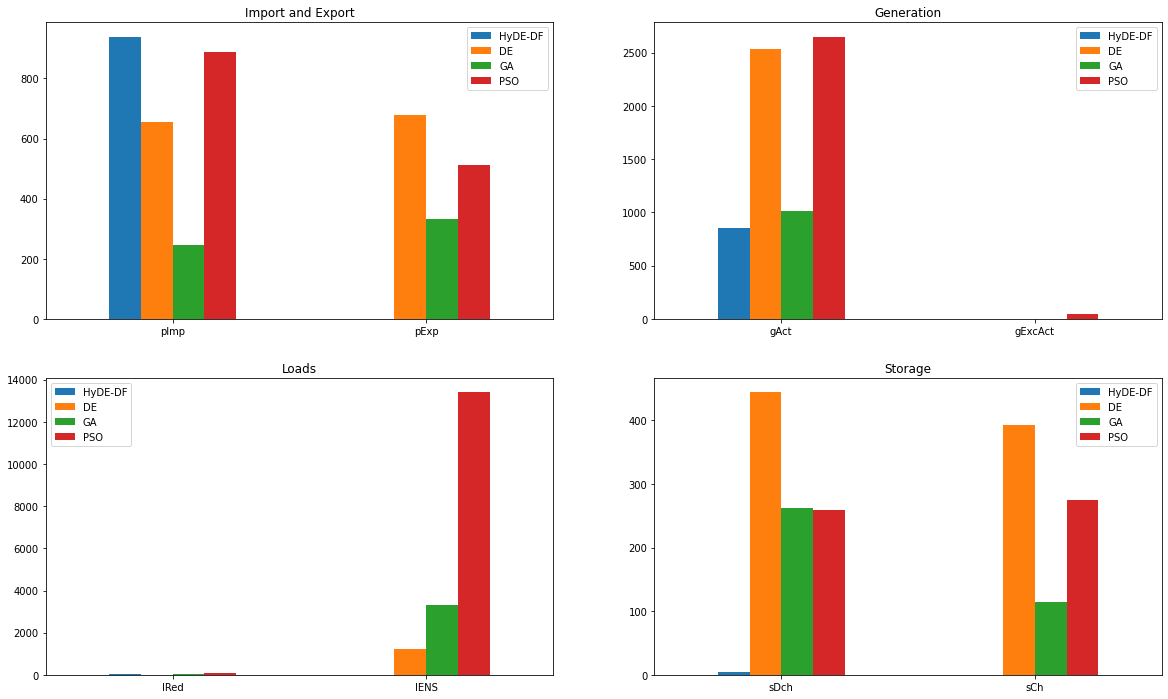

In [196]:
# Gather the sum data into a single dataframe

temp_keys = ['pImp', 'pExp', 'genActPower', 'genExcActPower', 'loadRedActPower', 'loadENS', 
             'storDchActPower', 'storChActPower']

temp_cols = ['pImp', 'pExp', 'gAct', 'gExcAct', 'lRed', 'lENS', 
             'sDch', 'sCh']

aggregated_sums = pd.DataFrame({'HyDE-DF': [np.sum(np.sum(results_hyde['run06'][key])) for key in temp_keys],
                                'DE': [np.sum(np.sum(decoded_de['run07'][key])) for key in temp_keys],
                                'GA': [np.sum(np.sum(decoded_ga['run02'][key])) for key in temp_keys],
                                'PSO': [np.sum(np.sum(decoded_pso['run09'][key])) for key in temp_keys]}, 
                               index=temp_cols)

fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(20, 12))
aggregated_sums.transpose()[['pImp', 'pExp']].transpose().plot(kind='bar', ax=axs[0, 0])
aggregated_sums.transpose()[['gAct', 'gExcAct']].transpose().plot(kind='bar', ax=axs[0, 1])
aggregated_sums.transpose()[['lRed', 'lENS']].transpose().plot(kind='bar', ax=axs[1, 0])
aggregated_sums.transpose()[['sDch', 'sCh']].transpose().plot(kind='bar', ax=axs[1, 1])

axs[0, 0].set_title('Import and Export')
axs[0, 0].set_xticklabels(['pImp', 'pExp'], rotation=0)

axs[0, 1].set_title('Generation')
axs[0, 1].set_xticklabels(['gAct', 'gExcAct'], rotation=0)

axs[1, 0].set_title('Loads')
axs[1, 0].set_xticklabels(['lRed', 'lENS'], rotation=0)

axs[1, 1].set_title('Storage')
axs[1, 1].set_xticklabels(['sDch', 'sCh'], rotation=0)

plt.show()

In [324]:
# Get the objective function values aggregated

df_objFn = pd.DataFrame({'HyDE-DF': [results_hyde['run{:02d}'.format(i)]['overall']['Fit'].values[0]
                                     for i in np.arange(1, 11)],
                         'DE': [results_de['run{:02d}'.format(i)]['stats']['objFun'].values[0]
                                for i in np.arange(1, 11)],
                         'GA': [results_ga['run{:02d}'.format(i)]['stats']['objFun'].values[0]
                                for i in np.arange(1, 11)],
                         'PSO': [results_pso['run{:02d}'.format(i)]['stats']['objFun'].values[0]
                                 for i in np.arange(1, 11)]})

In [330]:
df_objFn.describe()

,HyDE-DF,DE,GA,PSO
count,10.000000,10.000000,10.000000,10.000000
mean,170.608476,521.574447,2120.867148,24161.197414
std,5.715191,118.222750,348.781413,41779.284825
min,160.196435,365.943230,1515.116866,3955.597239
25%,168.036601,431.297826,2014.341531,4081.475358
50%,172.434228,501.210004,2150.009291,4459.851894
75%,174.200321,632.464232,2280.443755,4860.565394
max,178.647810,673.836619,2782.969453,103445.242273


In [301]:
# Aggregate the consumption and production of the solutions -  HyDE-DF

# Consumption:
# - loads
# - battery charging
# - energy exports

# Productions:
# - generators
# - battery discharging
# - energy imports

# Consumption:

df_hyde_cons = pd.DataFrame({'loadActPower': np.sum(results_hyde['run05']['loadActPower'], axis=0),
                             'genExcActPower': np.sum(results_hyde['run05']['genExcActPower'], axis=0),
                             'csActPower': np.sum(results_hyde['run05']['csActPower'], axis=0),
                             'pExp': results_hyde['run05']['pExp'].values.ravel(),
                             'storChActPower': np.sum(results_hyde['run05']['storChActPower'], axis=0)})
df_hyde_cons.index = ['{:02d}:00'.format(i) for i in np.arange(24)]

df_hyde_prod = pd.DataFrame({'genAcPower': np.sum(results_hyde['run05']['genActPower'], axis=0),
                             'pImp': results_hyde['run05']['pImp'].values.ravel(),
                             'storDchActPower': np.sum(results_hyde['run05']['storDchActPower'], axis=0),
                             'v2gDchActPower': np.sum(results_hyde['run05']['v2gDchActPower'], axis=0),
                             'loadCutActPower': np.sum(results_hyde['run05']['loadCutActPower'], axis=0),
                             'loadRedActPower': np.sum(results_hyde['run05']['loadRedActPower'], axis=0),
                             'loadENS': np.sum(results_hyde['run05']['loadENS'], axis=0)})
df_hyde_prod.index = ['{:02d}:00'.format(i) for i in np.arange(24)]

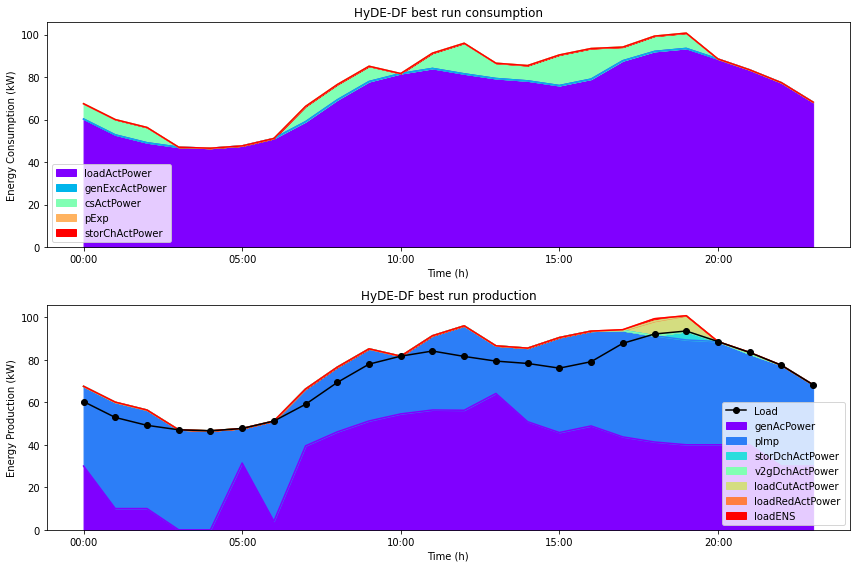

In [314]:
# HyDE-DF best run results for consumption and production

fig, axs = plt.subplots(nrows=2, figsize=(12, 8))

df_hyde_cons.plot.area(ax=axs[0], cmap='rainbow')
axs[0].set_title('HyDE-DF best run consumption')
axs[0].set_ylabel('Energy Consumption (kW)')
axs[0].set_xlabel('Time (h)')

df_hyde_prod.plot.area(ax=axs[1], cmap='rainbow')
axs[1].plot(np.sum(results_hyde['run04']['loadActPower'], axis=0), 'o-', label='Load', color='black')
axs[1].legend()
axs[1].set_title('HyDE-DF best run production')
axs[1].set_ylabel('Energy Production (kW)')
axs[1].set_xlabel('Time (h)')

plt.tight_layout()

plt.show()

In [307]:
# Aggregate the consumption and production of the solutions -  GA

# Consumption:
# - loads
# - battery charging
# - energy exports
# - genExc

# Productions:
# - generators
# - battery discharging
# - energy imports

# Consumption:

df_ga_cons = pd.DataFrame({'loadActPower': np.sum(results_hyde['run05']['loadActPower'], axis=0),
                           'genExcActPower': np.sum(decoded_ga['run07']['genExcActPower'], axis=0),
                           'csActPower': np.sum(results_hyde['run05']['csActPower'], axis=0),
                           'pExp': decoded_ga['run07']['pExp'],
                           'storChActPower': np.sum(decoded_ga['run07']['storChActPower'], axis=0)})
df_ga_cons.index = ['{:02d}:00'.format(i) for i in np.arange(24)]

df_ga_prod = pd.DataFrame({'genAcPower': np.sum(decoded_ga['run07']['genActPower'], axis=0),
                           'pImp': decoded_ga['run07']['pImp'],
                           'storDchActPower': np.sum(decoded_ga['run07']['storDchActPower'], axis=0),
                           'v2gDchActPower': np.sum(results_hyde['run04']['v2gDchActPower'], axis=0),
                           'loadCutActPower': np.sum(results_hyde['run04']['loadCutActPower'], axis=0),
                           'loadRedActPower': np.sum(decoded_ga['run07']['loadRedActPower'], axis=0),
                           'loadENS': np.sum(decoded_ga['run07']['loadENS'], axis=0)})
df_ga_prod.index = ['{:02d}:00'.format(i) for i in np.arange(24)]

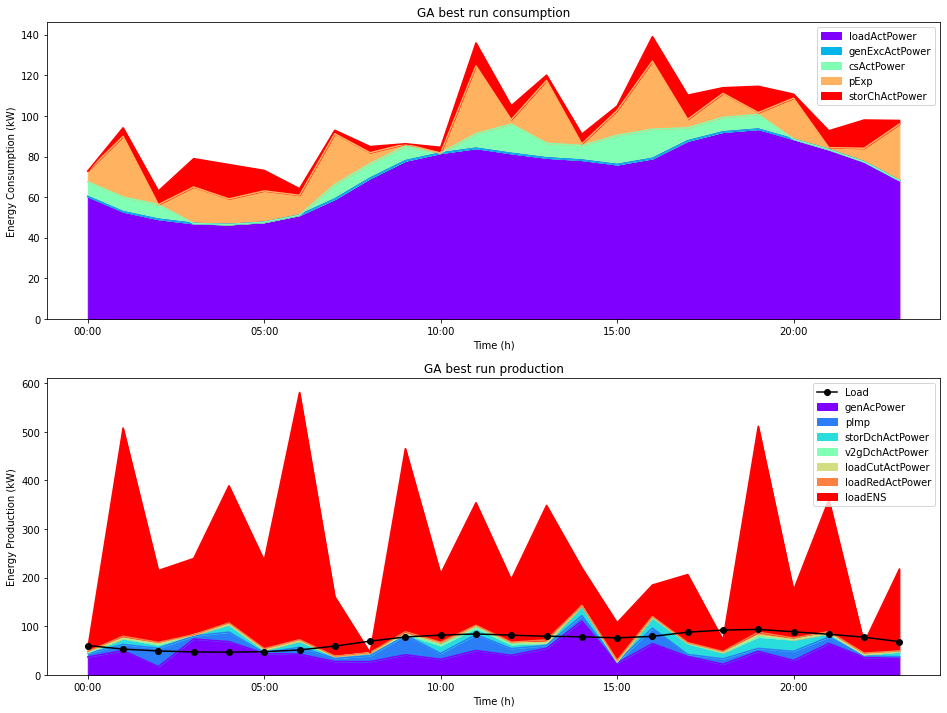

In [309]:
# GA best run results for consumption and production

fig, axs = plt.subplots(nrows=2, figsize=(16, 12))

df_ga_cons.plot.area(ax=axs[0], cmap='rainbow')
axs[0].set_title('GA best run consumption')
axs[0].set_ylabel('Energy Consumption (kW)')
axs[0].set_xlabel('Time (h)')

df_ga_prod.plot.area(ax=axs[1], cmap='rainbow')
axs[1].plot(np.sum(results_hyde['run04']['loadActPower'], axis=0), 'o-', label='Load', color='black')
axs[1].legend()
axs[1].set_title('GA best run production')
axs[1].set_ylabel('Energy Production (kW)')
axs[1].set_xlabel('Time (h)')

plt.show()